In [2]:
pip install torchinfo

In [3]:
import zipfile
from io import BytesIO
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torchinfo import summary
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
from itertools import cycle

Total number of images: 100800
Number of classes: 36
Class 0: 2800 images
Class 1: 2800 images
Class 2: 2800 images
Class 3: 2800 images
Class 4: 2800 images
Class 5: 2800 images
Class 6: 2800 images
Class 7: 2800 images
Class 8: 2800 images
Class 9: 2800 images
Class A: 2800 images
Class B: 2800 images
Class C: 2800 images
Class D: 2800 images
Class E: 2800 images
Class F: 2800 images
Class G: 2800 images
Class H: 2800 images
Class I: 2800 images
Class J: 2800 images
Class K: 2800 images
Class L: 2800 images
Class M: 2800 images
Class N: 2800 images
Class O: 2800 images
Class P: 2800 images
Class Q: 2800 images
Class R: 2800 images
Class S: 2800 images
Class T: 2800 images
Class U: 2800 images
Class V: 2800 images
Class W: 2800 images
Class X: 2800 images
Class Y: 2800 images
Class Z: 2800 images


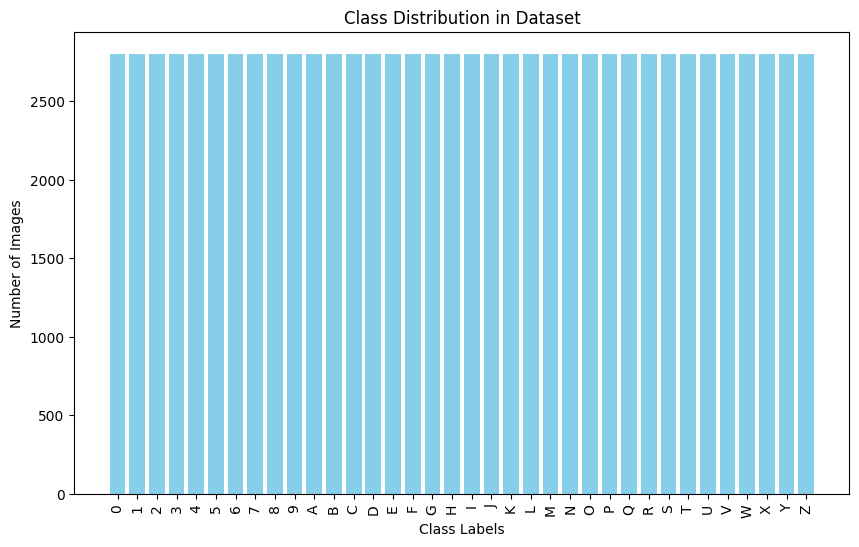

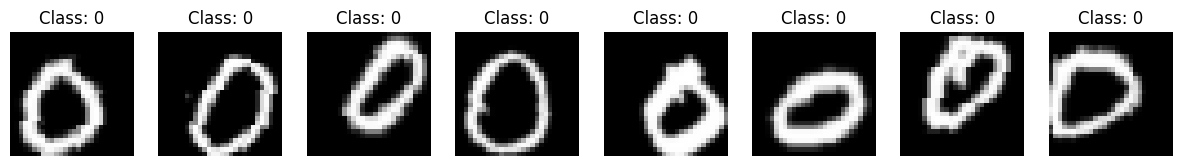

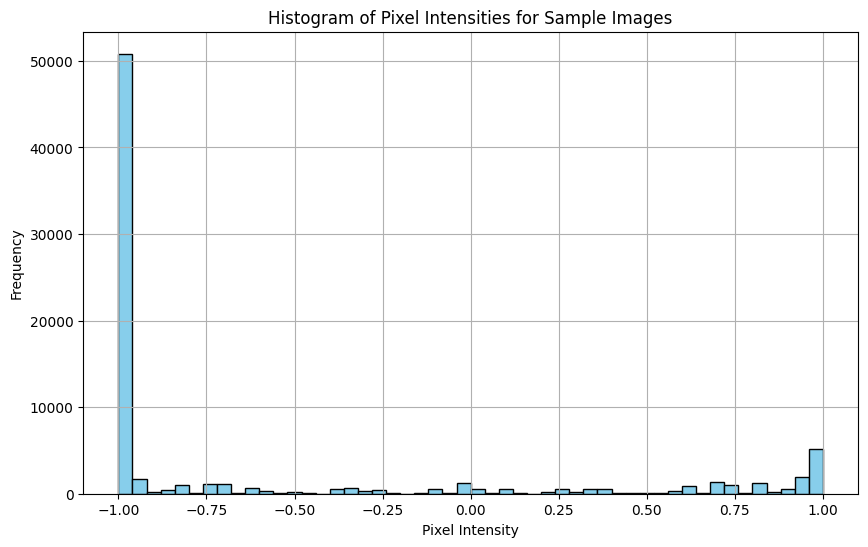

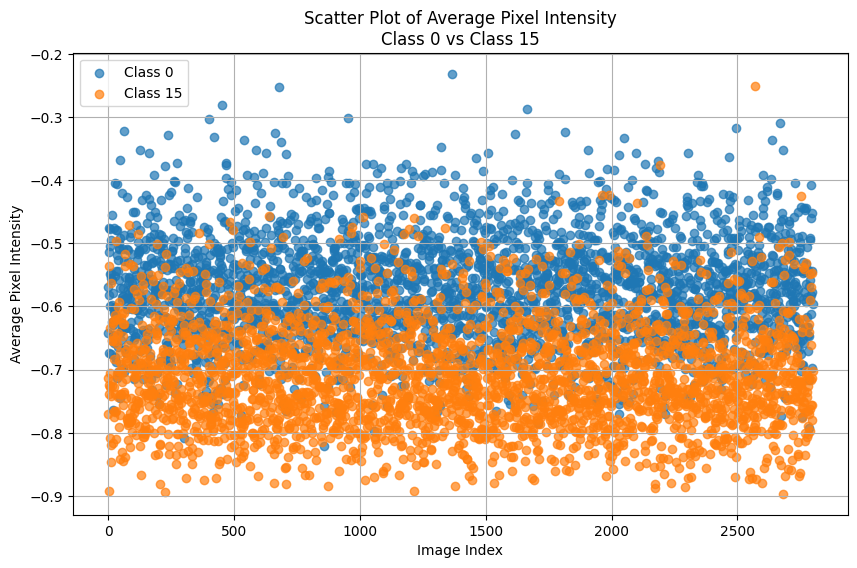

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


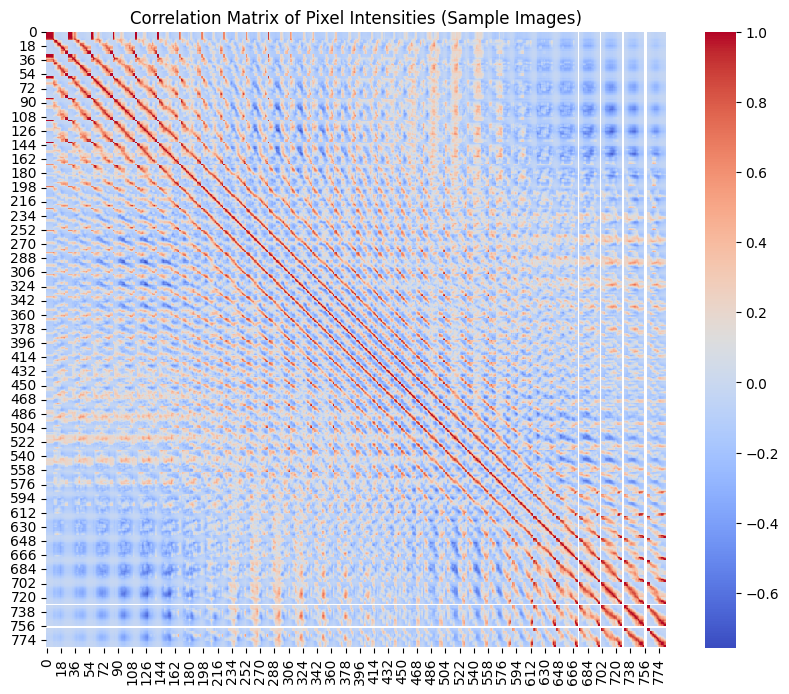

In [4]:
#Loading the dataset from zip file directly
class LocalZipImageDataset(Dataset):
    def __init__(self, zip_path, transform=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        # Opening the ZIP file
        with zipfile.ZipFile(zip_path, 'r') as zip_file:
            # Gathering the image paths and labels
            for file in zip_file.namelist():
                if file.endswith('.jpg') or file.endswith('.png'):
                    # Extracting the class name from the folder structure within ZIP
                    class_name = file.split('/')[-2]
                    if class_name not in self.class_to_idx:
                        self.class_to_idx[class_name] = len(self.class_to_idx)
                    self.image_paths.append(file)
                    self.labels.append(self.class_to_idx[class_name])

        # Keeping the zip file in memory
        self.zip_file = zipfile.ZipFile(zip_path, 'r')

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        with self.zip_file.open(img_path) as file:
            image = Image.open(file).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

#Data Augmentation - for model improvement and also data preprocessing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),           # Randomly flip images horizontally
    transforms.RandomRotation(10),              # Randomly rotate images by up to 10 degrees
    transforms.RandomCrop(28, padding=4),       # Randomly crop images with padding
    transforms.Grayscale(num_output_channels=1),# Convert to grayscale - preprocessing
    transforms.ToTensor(),                      # Convert to tensor - preprocessing
    transforms.Normalize((0.5,), (0.5,))        # Normalize - preprocessing
])

zip_path = 'cnn_dataset.zip'
dataset = LocalZipImageDataset(zip_path=zip_path, transform=transform)



# Analyzing the dataset
def analyze_dataset(dataset):
    label_counts = Counter(dataset.labels)
    classes = list(dataset.class_to_idx.keys())

    print(f"Total number of images: {len(dataset)}")
    print(f"Number of classes: {len(classes)}")

    # Printing counts for each class
    for cls, idx in dataset.class_to_idx.items():
        print(f"Class {cls}: {label_counts[idx]} images")

    # Plotting the class distribution
    plt.figure(figsize=(10, 6))
    plt.bar(classes, [label_counts[idx] for idx in range(len(classes))], color='skyblue')
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution in Dataset')
    plt.xticks(rotation=90)
    plt.show()


# Calling the analyze function
analyze_dataset(dataset)

#Visualising the dataset
def visualize_samples(dataset, num_samples=8):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        image, label = dataset[i]
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f"Class: {list(dataset.class_to_idx.keys())[label]}")
        axes[i].axis('off')
    plt.show()

# Histogram of Image Pixel Intensities (for a subset of the dataset)
def plot_pixel_intensity_histogram(dataset, num_images=100):
    pixel_values = []
    for i in range(num_images):
        image, _ = dataset[i]
        pixel_values.extend(image.numpy().flatten())

    plt.figure(figsize=(10, 6))
    plt.hist(pixel_values, bins=50, color='skyblue', edgecolor='black')
    plt.title('Histogram of Pixel Intensities for Sample Images')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Scatter Plot of Average Pixel Intensity per Image for Two Classes
def plot_avg_intensity_scatter(dataset, class_1, class_2):
    avg_intensity_class1 = []
    avg_intensity_class2 = []

    for image, label in dataset:
        avg_intensity = image.numpy().mean()
        if label == class_1:
            avg_intensity_class1.append(avg_intensity)
        elif label == class_2:
            avg_intensity_class2.append(avg_intensity)

    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(avg_intensity_class1)), avg_intensity_class1, label=f'Class {class_1}', alpha=0.7)
    plt.scatter(range(len(avg_intensity_class2)), avg_intensity_class2, label=f'Class {class_2}', alpha=0.7)
    plt.title(f'Scatter Plot of Average Pixel Intensity\nClass {class_1} vs Class {class_2}')
    plt.xlabel('Image Index')
    plt.ylabel('Average Pixel Intensity')
    plt.legend()
    plt.grid(True)
    plt.show()

# Correlation Matrix of Pixel Intensities for Selected Images
def plot_correlation_matrix(dataset, num_images=50):
    selected_images = []

    for i in range(num_images):
        image, _ = dataset[i]
        selected_images.append(image.numpy().flatten())

    pixel_matrix = np.array(selected_images).T  # Transpose for correlation calculation
    correlation_matrix = np.corrcoef(pixel_matrix)

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, cbar=True)
    plt.title('Correlation Matrix of Pixel Intensities (Sample Images)')
    plt.show()

# Calling the visualization function
visualize_samples(dataset)
# Call the functions
plot_pixel_intensity_histogram(dataset)
plot_avg_intensity_scatter(dataset, class_1=0, class_2=15)  # Compare Class 0 and Class 15 as an example
plot_correlation_matrix(dataset)

# Splitting into train and test, then loading with DataLoaders
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

num_classes = len(dataset.class_to_idx)  # This gives the number of unique classes


In [ ]:
# To check if the unzipped file has images only
with zipfile.ZipFile(zip_path, 'r') as zip_file:
    print("Files in ZIP:", zip_file.namelist())

Files in ZIP: ['cnn_dataset/0/', 'cnn_dataset/0/100027.png', 'cnn_dataset/0/100059.png', 'cnn_dataset/0/100065.png', 'cnn_dataset/0/100078.png', 'cnn_dataset/0/100079.png', 'cnn_dataset/0/100168.png', 'cnn_dataset/0/100179.png', 'cnn_dataset/0/100188.png', 'cnn_dataset/0/100200.png', 'cnn_dataset/0/10041.png', 'cnn_dataset/0/100470.png', 'cnn_dataset/0/100495.png', 'cnn_dataset/0/100498.png', 'cnn_dataset/0/100509.png', 'cnn_dataset/0/10052.png', 'cnn_dataset/0/100550.png', 'cnn_dataset/0/100551.png', 'cnn_dataset/0/100555.png', 'cnn_dataset/0/100603.png', 'cnn_dataset/0/100648.png', 'cnn_dataset/0/100683.png', 'cnn_dataset/0/100728.png', 'cnn_dataset/0/100781.png', 'cnn_dataset/0/10082.png', 'cnn_dataset/0/100833.png', 'cnn_dataset/0/100843.png', 'cnn_dataset/0/100901.png', 'cnn_dataset/0/100954.png', 'cnn_dataset/0/101006.png', 'cnn_dataset/0/101028.png', 'cnn_dataset/0/101152.png', 'cnn_dataset/0/101186.png', 'cnn_dataset/0/101199.png', 'cnn_dataset/0/101225.png', 'cnn_dataset/0/101

In [ ]:
pip install torchinfo

In [ ]:


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Conv layers with ReLU activation fn
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        # Fully connected layers with 256 hidden neurons
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 36)  # Since we have 36 classes

    def forward(self, x):
        # Forward pass throught conv layers
        x = F.relu(self.bn1(self.conv1(x))) # Applying Batch Normalization after conv1 and before ReLU
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x))) # Applying Batch Normalization after conv2 and before ReLU
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x))) # Applying Batch Normalization after conv3 and before ReLU
        x = F.max_pool2d(x, 2)

        # Flatten the feature maps for fully connected layers
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#weight initialization
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model = CNNModel()
model.apply(init_weights)

# Printing the model summary
print(summary(model, input_size=(64, 1, 28, 28)))


Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [64, 36]                  --
├─Conv2d: 1-1                            [64, 32, 28, 28]          320
├─BatchNorm2d: 1-2                       [64, 32, 28, 28]          64
├─Conv2d: 1-3                            [64, 64, 14, 14]          18,496
├─BatchNorm2d: 1-4                       [64, 64, 14, 14]          128
├─Conv2d: 1-5                            [64, 128, 7, 7]           73,856
├─BatchNorm2d: 1-6                       [64, 128, 7, 7]           256
├─Linear: 1-7                            [64, 256]                 295,168
├─Linear: 1-8                            [64, 36]                  9,252
Total params: 397,540
Trainable params: 397,540
Non-trainable params: 0
Total mult-adds (M): 499.19
Input size (MB): 0.20
Forward/backward pass size (MB): 45.11
Params size (MB): 1.59
Estimated Total Size (MB): 46.90


In [ ]:



# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Defining scheduler - to adjust the learning rate dynamically
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Initializing lists to store losses and accuracies
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

#Early stopping - To prevent overfitting, implementing early stopping based on validation loss.
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


# Training loop
num_epochs = 10
early_stopping = EarlyStopping(patience=3, delta=0.01)

best_val_loss = float('inf')  # Initializing best validation loss

# Start timer
start_time = time.time()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0  # Initializing total training samples for the epoch
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Average training loss and accuracy for the epoch
    epoch_train_loss = running_loss / len(train_loader)
    training_losses.append(epoch_train_loss)
    epoch_train_accuracy = 100 * correct_train / total_train
    training_accuracies.append(epoch_train_accuracy)


    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0  # Initializing total validation samples for the epoch

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Average validation loss and accuracies for the epoch
    epoch_val_loss = val_running_loss / len(test_loader)
    validation_losses.append(epoch_val_loss)
    epoch_val_accuracy = 100 * correct_val / total_val
    validation_accuracies.append(epoch_val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, "
          f"Training Accuracy: {epoch_train_accuracy:.2f}%, Validation Accuracy: {epoch_val_accuracy:.2f}%")

    # Saving model if validation loss improves
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_cnn_model.pth')  # Saving the best model weights
        print(f"Model saved at epoch {epoch+1} with validation loss: {epoch_val_loss:.4f}")

    # Checking for early stopping
    early_stopping(epoch_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break


    scheduler.step()

# End timer
end_time = time.time()
print(f"Total Training Time: {end_time - start_time:.2f} seconds")

Epoch [1/10], Training Loss: 1.0106, Validation Loss: 0.6065, Training Accuracy: 67.82%, Validation Accuracy: 79.80%
Model saved at epoch 1 with validation loss: 0.6065
Epoch [2/10], Training Loss: 0.5264, Validation Loss: 0.5090, Training Accuracy: 81.86%, Validation Accuracy: 82.01%
Model saved at epoch 2 with validation loss: 0.5090
Epoch [3/10], Training Loss: 0.4493, Validation Loss: 0.4645, Training Accuracy: 84.23%, Validation Accuracy: 83.91%
Model saved at epoch 3 with validation loss: 0.4645
Epoch [4/10], Training Loss: 0.4142, Validation Loss: 0.4212, Training Accuracy: 85.14%, Validation Accuracy: 84.76%
Model saved at epoch 4 with validation loss: 0.4212
Epoch [5/10], Training Loss: 0.3878, Validation Loss: 0.3760, Training Accuracy: 86.01%, Validation Accuracy: 86.37%
Model saved at epoch 5 with validation loss: 0.3760
Epoch [6/10], Training Loss: 0.3241, Validation Loss: 0.3391, Training Accuracy: 88.15%, Validation Accuracy: 87.96%
Model saved at epoch 6 with validation

In [ ]:


# Evaluating on test data
all_labels = []
all_preds = []
# Calculating prediction probabilities for ROC curve
all_probs = []

# Loading the saved weights
model.load_state_dict(torch.load('best_cnn_model.pth'))
model.eval()  # Setting the model to evaluation mode
test_loss = 0.0 # Calculating the test loss

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)

# Binarizing labels for multi-class ROC
all_labels_binarized = label_binarize(all_labels, classes=list(range(num_classes)))

# Computing ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculating test accuracy
test_accuracy = accuracy_score(all_labels, all_preds) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Averaging test loss
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

# Classification report for detailed metrics
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.class_to_idx.keys()))

<ipython-input-18-7a1213d741cf>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_cnn_model.pth'))


Test Accuracy: 88.52%
Test Loss: 0.3165
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.74      0.69       604
           1       0.52      0.80      0.63       570
           2       0.89      0.85      0.87       559
           3       0.94      0.95      0.94       553
           4       0.91      0.91      0.91       552
           5       0.88      0.89      0.89       597
           6       0.94      0.95      0.94       555
           7       0.93      0.96      0.94       496
           8       0.96      0.93      0.95       558
           9       0.91      0.90      0.90       558
           A       0.95      0.97      0.96       553
           B       0.94      0.96      0.95       577
           C       0.95      0.96      0.95       577
           D       0.89      0.89      0.89       571
           E       0.97      0.93      0.95       571
           F       0.94      0.95      0.95       570
           G      

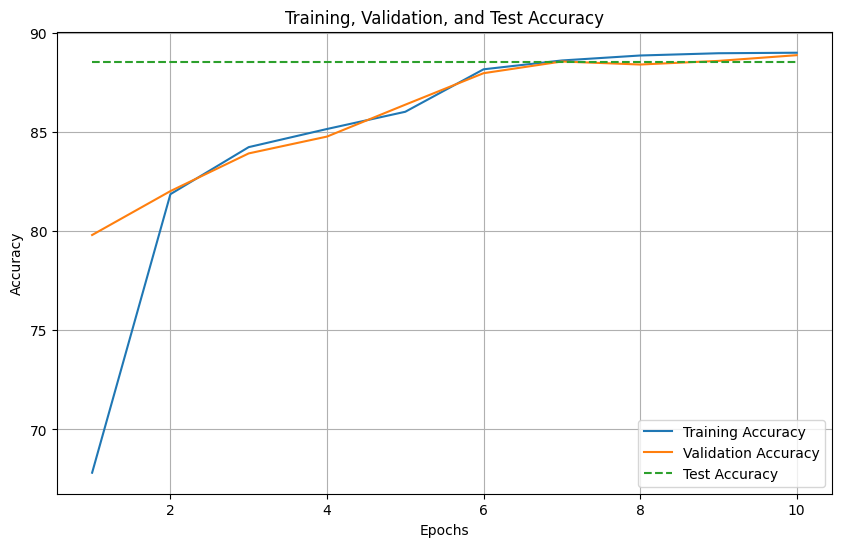

In [ ]:
# Generating a repeated test accuracy list for the number of epochs
test_accuracies = [test_accuracy] * num_epochs

# Plotting Training, Validation, and Test Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), validation_accuracies, label='Validation Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()


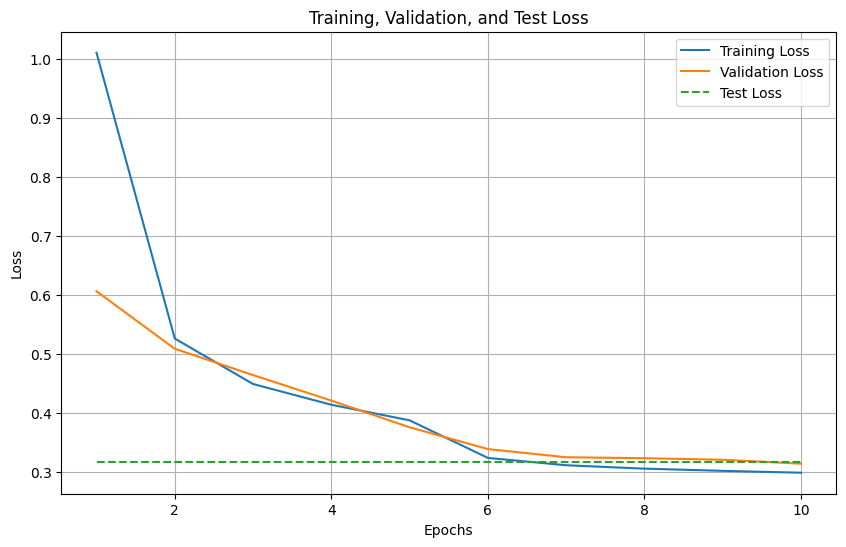

In [ ]:
test_losses = [test_loss] * num_epochs

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.grid(True)
plt.show()


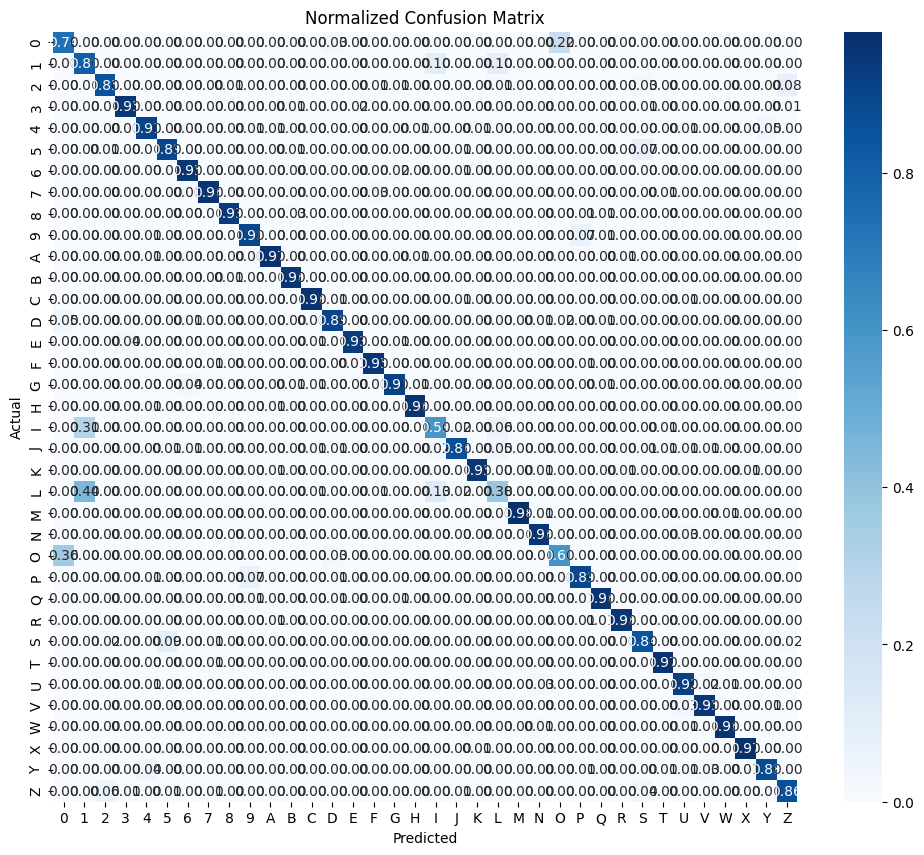

In [ ]:


conf_matrix = confusion_matrix(all_labels, all_preds, normalize='true')
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=dataset.class_to_idx.keys(),
            yticklabels=dataset.class_to_idx.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()


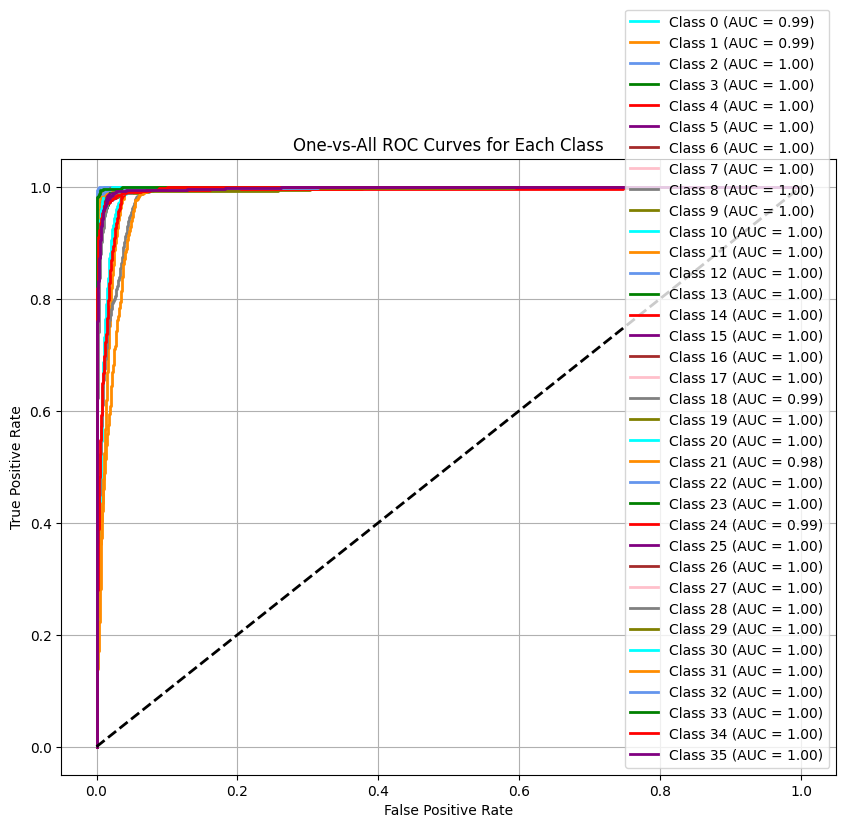

In [ ]:

# Ploting ROC Curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-All ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
torch.save(model.state_dict(), 'cnn_model_weights.pth')